#  I  made some modifications for this sample

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Plotting
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(3407)

# Args

In [2]:
class Args:
    def __init__(self) -> None:

        '''***********- model params -*************'''
        self.model_name = "hw1"

        '''***********- data path -*************'''
        self.data_path = '../../data/hw1/'
        self.train_file='covid.train.csv'
        self.val_file = ''
        self.test_file = 'covid.test.csv'
        self.submit_file = '../../submit/{}.csv'.format(self.model_name)

        '''***********- model path -*************'''
        self.MODEL_PATH = '../../ckpts/{}'.format(self.model_name)
        if not os.path.exists(self.MODEL_PATH):
            os.makedirs(self.MODEL_PATH)

        '''***********- cpu or gpu and dara parallel -*************'''
        # self.gpus = [] # cpu
        # self.gpus = [0] # single gpu
        self.gpus = [0] # multi gpu
        self.WORKERS = 5 # num of workers for data loader

        '''***********- Hyper Arguments -*************'''
        self.rand_seed=40
        self.batch_size = 256
        self.lr = 1e-3
        self.epochs = 200
        self.split_ratio = 0.2
        self.patience = 20
        self.l2_lambda = 0.1
        self.initial_lr = 1e-5
        self.warmup_epochs = 10

# Utils

In [3]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

# 定义warm-up调度器
def warmup_scheduler(optimizer, warmup_epochs, initial_lr, target_lr):
    delta_lr = (target_lr - initial_lr) / warmup_epochs
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return initial_lr + current_epoch * delta_lr
        return target_lr
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Model

In [5]:
# baseline
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.squeeze(1)
        return x

# Feature selection

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # 计算每个特征与y_train的相关系数
        correlations = np.array([np.corrcoef(raw_x_train[:, i], y_train)[0, 1] for i in range(raw_x_train.shape[1])])
        # 选择相关系数绝对值大于0.1的特征
        feat_idx = np.where(np.abs(correlations) > 0.1)[0]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Trainer

In [7]:
def trainer():
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)
    # Print out the data size.
    print(f"""train_data size: {train_data.shape} 
          valid_data size: {valid_data.shape} 
          test_data size: {test_data.shape}""")

    print("Selecting features...")
    x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, select_all=False)
    # Print out the number of features.
    print(f'number of features: {x_train.shape[1]}')

    train_dataset, val_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                                COVID19Dataset(x_valid, y_valid), \
                                                COVID19Dataset(x_test)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler_warmup = warmup_scheduler(optimizer, args.warmup_epochs, args.initial_lr, args.lr)
    scheduler_decay = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    print("***********- ***********- Training begin -*************")
    train_epochs_loss = []
    # train_epochs_mse = []
    valid_epochs_loss = []
    # valid_epochs_mse = []
    val_inf = np.inf
    patience_counter = 0
    for epoch in range(args.epochs):
        model.train()
        train_epoch_loss = []
        # train_epoch_mse = []
        # =========================train=======================
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            if (len(args.gpus) > 0):
                X, y = X.cuda(), y.cuda()

            # 计算 L2 正则化损失
            l2_reg = torch.tensor(0.).cuda()
            for param in model.parameters():
                l2_reg += torch.norm(param)
            
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, y) + args.l2_lambda * l2_reg
            # mse = torch.nn.functional.mse_loss(outputs, y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) #用来梯度裁剪
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # train_epoch_mse.append(mse.item())
        train_epochs_loss.append(np.average(train_epoch_loss))

        if epoch < args.warmup_epochs:
            scheduler_warmup.step(epoch)
        else:
            scheduler_decay.step(epoch)

        # train_epochs_mse.append(np.average(train_epoch_mse))
        # print("Train epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(train_epoch_loss), np.average(train_epoch_mse)))
        print("Train epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(train_epoch_loss)))
        # =========================val=========================
        with torch.no_grad():
            model.eval()
            val_epoch_loss = []
            # val_epoch_mse = []
            for idx, (X, y) in enumerate(tqdm(val_dataloader)):
                if (len(args.gpus) > 0):
                    X, y = X.cuda(), y.cuda()
                outputs = model(X)
                loss = criterion(outputs, y)
                # mse = torch.nn.functional.mse_loss(outputs, y)
                val_epoch_loss.append(loss.item())
                # val_epoch_mse.append(mse.item())
            if np.average(val_epoch_loss) < val_inf:
                val_inf = np.average(val_epoch_loss)
                torch.save(model.state_dict(), model_best_path)
                patience_counter = 0
            else:
                patience_counter += 1
            valid_epochs_loss.append(np.average(val_epoch_loss))
            # valid_epochs_mse.append(np.average(val_epoch_mse))
            # print("Valid epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(val_epoch_loss), np.average(val_epoch_mse)))
            print("Valid epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(val_epoch_loss)))
            if patience_counter >= args.patience:
                break
            
    torch.save(model.state_dict(), model_final_path)
    print("***********- ***********- Training finished -*************")
    return train_epochs_loss, valid_epochs_loss

# Train

In [8]:
train_epochs_loss, valid_epochs_loss = trainer()

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
train_data size: (2160, 118) 
          valid_data size: (539, 118) 
          test_data size: (1078, 117)
Selecting features...
number of features: 86
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Training begin -*************


100%|██████████| 9/9 [00:02<00:00,  3.71it/s]
/home/niuniu10/miniconda3/envs/cppcuda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train epoch = 1, loss = 81.7321


100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Valid epoch = 1, loss = 77.3805


100%|██████████| 9/9 [00:00<00:00, 17.20it/s]


Train epoch = 2, loss = 82.3795


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Valid epoch = 2, loss = 90.3996


100%|██████████| 9/9 [00:00<00:00, 16.27it/s]


Train epoch = 3, loss = 84.0492


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Valid epoch = 3, loss = 81.1260


100%|██████████| 9/9 [00:00<00:00, 16.54it/s]


Train epoch = 4, loss = 83.9289


100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Valid epoch = 4, loss = 84.0788


100%|██████████| 9/9 [00:00<00:00, 17.27it/s]


Train epoch = 5, loss = 82.7137


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Valid epoch = 5, loss = 71.2490


100%|██████████| 9/9 [00:00<00:00, 13.82it/s]


Train epoch = 6, loss = 83.9816


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Valid epoch = 6, loss = 80.4681


100%|██████████| 9/9 [00:00<00:00, 17.91it/s]


Train epoch = 7, loss = 82.3615


100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Valid epoch = 7, loss = 80.2016


100%|██████████| 9/9 [00:00<00:00, 17.62it/s]


Train epoch = 8, loss = 82.3258


100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


Valid epoch = 8, loss = 78.3543


100%|██████████| 9/9 [00:00<00:00, 17.26it/s]


Train epoch = 9, loss = 82.9223


100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Valid epoch = 9, loss = 83.3005


100%|██████████| 9/9 [00:00<00:00, 17.71it/s]


Train epoch = 10, loss = 82.1060


100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


Valid epoch = 10, loss = 73.4383


100%|██████████| 9/9 [00:00<00:00, 17.26it/s]


Train epoch = 11, loss = 82.7304


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Valid epoch = 11, loss = 78.0225


100%|██████████| 9/9 [00:00<00:00, 16.59it/s]


Train epoch = 12, loss = 59.2642


100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


Valid epoch = 12, loss = 59.5648


100%|██████████| 9/9 [00:00<00:00, 17.43it/s]


Train epoch = 13, loss = 50.2456


100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


Valid epoch = 13, loss = 36.0478


100%|██████████| 9/9 [00:00<00:00, 16.94it/s]


Train epoch = 14, loss = 36.3921


100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Valid epoch = 14, loss = 32.2190


100%|██████████| 9/9 [00:00<00:00, 16.76it/s]


Train epoch = 15, loss = 30.7063


100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


Valid epoch = 15, loss = 24.9015


100%|██████████| 9/9 [00:00<00:00, 17.02it/s]


Train epoch = 16, loss = 25.5870


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


Valid epoch = 16, loss = 22.5453


100%|██████████| 9/9 [00:00<00:00, 16.33it/s]


Train epoch = 17, loss = 21.3014


100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Valid epoch = 17, loss = 18.2335


100%|██████████| 9/9 [00:00<00:00, 16.41it/s]


Train epoch = 18, loss = 16.0223


100%|██████████| 3/3 [00:00<00:00,  6.24it/s]


Valid epoch = 18, loss = 11.1341


100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Train epoch = 19, loss = 11.2681


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Valid epoch = 19, loss = 7.8785


100%|██████████| 9/9 [00:00<00:00, 17.69it/s]


Train epoch = 20, loss = 8.0256


100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Valid epoch = 20, loss = 7.0140


100%|██████████| 9/9 [00:00<00:00, 16.64it/s]


Train epoch = 21, loss = 7.3168


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Valid epoch = 21, loss = 5.5674


100%|██████████| 9/9 [00:00<00:00, 16.85it/s]


Train epoch = 22, loss = 7.0613


100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


Valid epoch = 22, loss = 5.8688


100%|██████████| 9/9 [00:00<00:00, 17.08it/s]


Train epoch = 23, loss = 6.6704


100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


Valid epoch = 23, loss = 5.0327


100%|██████████| 9/9 [00:00<00:00, 16.73it/s]


Train epoch = 24, loss = 6.5555


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Valid epoch = 24, loss = 6.8353


100%|██████████| 9/9 [00:00<00:00, 17.48it/s]


Train epoch = 25, loss = 6.3645


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


Valid epoch = 25, loss = 5.0682


100%|██████████| 9/9 [00:00<00:00, 16.30it/s]


Train epoch = 26, loss = 6.1770


100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Valid epoch = 26, loss = 6.5151


100%|██████████| 9/9 [00:00<00:00, 17.18it/s]


Train epoch = 27, loss = 6.2816


100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Valid epoch = 27, loss = 4.7530


100%|██████████| 9/9 [00:00<00:00, 17.64it/s]


Train epoch = 28, loss = 5.9620


100%|██████████| 3/3 [00:00<00:00,  6.60it/s]


Valid epoch = 28, loss = 5.3246


100%|██████████| 9/9 [00:00<00:00, 16.91it/s]


Train epoch = 29, loss = 5.9213


100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


Valid epoch = 29, loss = 4.3189


100%|██████████| 9/9 [00:00<00:00, 16.86it/s]


Train epoch = 30, loss = 5.7795


100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


Valid epoch = 30, loss = 4.6911


100%|██████████| 9/9 [00:00<00:00, 17.56it/s]


Train epoch = 31, loss = 5.6097


100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Valid epoch = 31, loss = 4.8723


100%|██████████| 9/9 [00:00<00:00, 15.79it/s]


Train epoch = 32, loss = 5.5659


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Valid epoch = 32, loss = 4.1761


100%|██████████| 9/9 [00:00<00:00, 13.49it/s]


Train epoch = 33, loss = 5.4676


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Valid epoch = 33, loss = 4.2394


100%|██████████| 9/9 [00:00<00:00, 13.41it/s]


Train epoch = 34, loss = 5.2810


100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Valid epoch = 34, loss = 3.9118


100%|██████████| 9/9 [00:00<00:00, 13.40it/s]


Train epoch = 35, loss = 5.3272


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Valid epoch = 35, loss = 3.6123


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Train epoch = 36, loss = 5.2358


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Valid epoch = 36, loss = 4.4329


100%|██████████| 9/9 [00:00<00:00, 11.25it/s]


Train epoch = 37, loss = 5.0497


100%|██████████| 3/3 [00:00<00:00,  5.88it/s]


Valid epoch = 37, loss = 4.2538


100%|██████████| 9/9 [00:00<00:00, 12.76it/s]


Train epoch = 38, loss = 4.9700


100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


Valid epoch = 38, loss = 3.3131


100%|██████████| 9/9 [00:00<00:00, 13.77it/s]


Train epoch = 39, loss = 4.8052


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 39, loss = 3.1593


100%|██████████| 9/9 [00:00<00:00, 12.99it/s]


Train epoch = 40, loss = 4.6255


100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Valid epoch = 40, loss = 3.6406


100%|██████████| 9/9 [00:00<00:00, 13.78it/s]


Train epoch = 41, loss = 4.5863


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Valid epoch = 41, loss = 3.2040


100%|██████████| 9/9 [00:00<00:00, 13.62it/s]


Train epoch = 42, loss = 4.5029


100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


Valid epoch = 42, loss = 3.2377


100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


Train epoch = 43, loss = 4.3623


100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


Valid epoch = 43, loss = 3.0110


100%|██████████| 9/9 [00:00<00:00, 13.55it/s]


Train epoch = 44, loss = 4.2718


100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Valid epoch = 44, loss = 3.0654


100%|██████████| 9/9 [00:00<00:00, 13.78it/s]


Train epoch = 45, loss = 4.2260


100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


Valid epoch = 45, loss = 2.7121


100%|██████████| 9/9 [00:00<00:00, 10.84it/s]


Train epoch = 46, loss = 4.2576


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


Valid epoch = 46, loss = 3.0506


100%|██████████| 9/9 [00:00<00:00, 11.87it/s]


Train epoch = 47, loss = 4.0515


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Valid epoch = 47, loss = 2.6395


100%|██████████| 9/9 [00:00<00:00, 12.71it/s]


Train epoch = 48, loss = 3.9588


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Valid epoch = 48, loss = 2.6301


100%|██████████| 9/9 [00:00<00:00, 13.59it/s]


Train epoch = 49, loss = 4.0505


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Valid epoch = 49, loss = 2.3836


100%|██████████| 9/9 [00:00<00:00, 12.74it/s]


Train epoch = 50, loss = 4.0544


100%|██████████| 3/3 [00:00<00:00,  4.95it/s]


Valid epoch = 50, loss = 2.5474


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


Train epoch = 51, loss = 4.0439


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Valid epoch = 51, loss = 2.4514


100%|██████████| 9/9 [00:00<00:00, 12.99it/s]


Train epoch = 52, loss = 3.9087


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Valid epoch = 52, loss = 2.4110


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


Train epoch = 53, loss = 3.8825


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Valid epoch = 53, loss = 2.9224


100%|██████████| 9/9 [00:00<00:00, 13.08it/s]


Train epoch = 54, loss = 3.6755


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Valid epoch = 54, loss = 2.1703


100%|██████████| 9/9 [00:00<00:00, 13.04it/s]


Train epoch = 55, loss = 3.6412


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Valid epoch = 55, loss = 2.1163


100%|██████████| 9/9 [00:00<00:00, 12.80it/s]


Train epoch = 56, loss = 3.6418


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Valid epoch = 56, loss = 2.0923


100%|██████████| 9/9 [00:00<00:00, 12.35it/s]


Train epoch = 57, loss = 3.6763


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Valid epoch = 57, loss = 2.7878


100%|██████████| 9/9 [00:00<00:00, 13.58it/s]


Train epoch = 58, loss = 3.5255


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Valid epoch = 58, loss = 2.4578


100%|██████████| 9/9 [00:00<00:00, 12.82it/s]


Train epoch = 59, loss = 3.5936


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Valid epoch = 59, loss = 1.9529


100%|██████████| 9/9 [00:00<00:00, 13.15it/s]


Train epoch = 60, loss = 3.5030


100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


Valid epoch = 60, loss = 2.3691


100%|██████████| 9/9 [00:00<00:00, 13.49it/s]


Train epoch = 61, loss = 3.5140


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Valid epoch = 61, loss = 2.3875


100%|██████████| 9/9 [00:00<00:00, 13.50it/s]


Train epoch = 62, loss = 3.5436


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Valid epoch = 62, loss = 2.1226


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


Train epoch = 63, loss = 3.4529


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Valid epoch = 63, loss = 2.3067


100%|██████████| 9/9 [00:00<00:00, 10.71it/s]


Train epoch = 64, loss = 3.3982


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Valid epoch = 64, loss = 2.0071


100%|██████████| 9/9 [00:00<00:00, 15.96it/s]


Train epoch = 65, loss = 3.3896


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Valid epoch = 65, loss = 1.8631


100%|██████████| 9/9 [00:00<00:00, 16.56it/s]


Train epoch = 66, loss = 3.3551


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Valid epoch = 66, loss = 1.9115


100%|██████████| 9/9 [00:00<00:00, 17.02it/s]


Train epoch = 67, loss = 3.3756


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Valid epoch = 67, loss = 1.8778


100%|██████████| 9/9 [00:00<00:00, 17.13it/s]


Train epoch = 68, loss = 3.3539


100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Valid epoch = 68, loss = 2.2339


100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


Train epoch = 69, loss = 3.4029


100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Valid epoch = 69, loss = 1.8081


100%|██████████| 9/9 [00:00<00:00, 16.59it/s]


Train epoch = 70, loss = 3.4307


100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Valid epoch = 70, loss = 2.0291


100%|██████████| 9/9 [00:00<00:00, 17.38it/s]


Train epoch = 71, loss = 3.3246


100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


Valid epoch = 71, loss = 2.1271


100%|██████████| 9/9 [00:00<00:00, 17.06it/s]


Train epoch = 72, loss = 3.3376


100%|██████████| 3/3 [00:00<00:00,  5.84it/s]


Valid epoch = 72, loss = 2.1909


100%|██████████| 9/9 [00:00<00:00, 16.48it/s]


Train epoch = 73, loss = 3.2809


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Valid epoch = 73, loss = 1.7194


100%|██████████| 9/9 [00:00<00:00, 16.03it/s]


Train epoch = 74, loss = 3.2998


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Valid epoch = 74, loss = 1.7881


100%|██████████| 9/9 [00:00<00:00, 14.94it/s]


Train epoch = 75, loss = 3.2482


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Valid epoch = 75, loss = 1.6515


100%|██████████| 9/9 [00:00<00:00, 17.42it/s]


Train epoch = 76, loss = 3.2834


100%|██████████| 3/3 [00:00<00:00,  5.61it/s]


Valid epoch = 76, loss = 2.0136


100%|██████████| 9/9 [00:00<00:00, 14.92it/s]


Train epoch = 77, loss = 3.3602


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Valid epoch = 77, loss = 2.0079


100%|██████████| 9/9 [00:00<00:00, 16.11it/s]


Train epoch = 78, loss = 3.3192


100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Valid epoch = 78, loss = 1.6412


100%|██████████| 9/9 [00:00<00:00, 17.32it/s]


Train epoch = 79, loss = 3.1995


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Valid epoch = 79, loss = 1.8629


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


Train epoch = 80, loss = 3.1965


100%|██████████| 3/3 [00:00<00:00,  6.54it/s]


Valid epoch = 80, loss = 2.4102


100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Train epoch = 81, loss = 3.2534


100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Valid epoch = 81, loss = 1.9492


100%|██████████| 9/9 [00:00<00:00, 15.36it/s]


Train epoch = 82, loss = 3.1798


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Valid epoch = 82, loss = 1.6435


100%|██████████| 9/9 [00:00<00:00, 16.74it/s]


Train epoch = 83, loss = 3.1731


100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Valid epoch = 83, loss = 1.8094


100%|██████████| 9/9 [00:00<00:00, 17.58it/s]


Train epoch = 84, loss = 3.1987


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Valid epoch = 84, loss = 1.6815


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]


Train epoch = 85, loss = 3.2204


100%|██████████| 3/3 [00:00<00:00,  6.30it/s]


Valid epoch = 85, loss = 2.0769


100%|██████████| 9/9 [00:00<00:00, 17.00it/s]


Train epoch = 86, loss = 3.1621


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Valid epoch = 86, loss = 1.9012


100%|██████████| 9/9 [00:00<00:00, 17.45it/s]


Train epoch = 87, loss = 3.1759


100%|██████████| 3/3 [00:00<00:00,  6.46it/s]


Valid epoch = 87, loss = 1.5709


100%|██████████| 9/9 [00:00<00:00, 16.56it/s]


Train epoch = 88, loss = 3.1515


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Valid epoch = 88, loss = 1.5872


100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Train epoch = 89, loss = 3.1416


100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Valid epoch = 89, loss = 2.2083


100%|██████████| 9/9 [00:00<00:00, 17.40it/s]


Train epoch = 90, loss = 3.1227


100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Valid epoch = 90, loss = 1.6085


100%|██████████| 9/9 [00:00<00:00, 15.98it/s]


Train epoch = 91, loss = 3.1287


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Valid epoch = 91, loss = 1.5797


100%|██████████| 9/9 [00:00<00:00, 16.66it/s]


Train epoch = 92, loss = 3.1335


100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Valid epoch = 92, loss = 1.9271


100%|██████████| 9/9 [00:00<00:00, 17.48it/s]


Train epoch = 93, loss = 3.2634


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Valid epoch = 93, loss = 1.7090


100%|██████████| 9/9 [00:00<00:00, 15.91it/s]


Train epoch = 94, loss = 3.1789


100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


Valid epoch = 94, loss = 1.9930


100%|██████████| 9/9 [00:00<00:00, 17.00it/s]


Train epoch = 95, loss = 3.1688


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Valid epoch = 95, loss = 2.0168


100%|██████████| 9/9 [00:00<00:00, 17.22it/s]


Train epoch = 96, loss = 3.1353


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Valid epoch = 96, loss = 2.1233


100%|██████████| 9/9 [00:00<00:00, 16.42it/s]


Train epoch = 97, loss = 3.1638


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Valid epoch = 97, loss = 1.8031


100%|██████████| 9/9 [00:00<00:00, 17.33it/s]


Train epoch = 98, loss = 3.1593


100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


Valid epoch = 98, loss = 1.8411


100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


Train epoch = 99, loss = 3.1600


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


Valid epoch = 99, loss = 1.9814


100%|██████████| 9/9 [00:00<00:00, 15.23it/s]


Train epoch = 100, loss = 3.0948


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Valid epoch = 100, loss = 1.6359


100%|██████████| 9/9 [00:00<00:00, 15.22it/s]


Train epoch = 101, loss = 3.0927


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Valid epoch = 101, loss = 2.2048


100%|██████████| 9/9 [00:00<00:00, 15.47it/s]


Train epoch = 102, loss = 3.0993


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Valid epoch = 102, loss = 1.9740


100%|██████████| 9/9 [00:00<00:00, 16.17it/s]


Train epoch = 103, loss = 3.0673


100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


Valid epoch = 103, loss = 1.6725


100%|██████████| 9/9 [00:00<00:00, 17.78it/s]


Train epoch = 104, loss = 3.1252


100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


Valid epoch = 104, loss = 1.7595


100%|██████████| 9/9 [00:00<00:00, 17.29it/s]


Train epoch = 105, loss = 3.0554


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Valid epoch = 105, loss = 2.0485


100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


Train epoch = 106, loss = 3.0993


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Valid epoch = 106, loss = 1.9098


100%|██████████| 9/9 [00:00<00:00, 17.29it/s]


Train epoch = 107, loss = 3.0952


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

Valid epoch = 107, loss = 1.6707
***********- ***********- Training finished -*************


# Plot

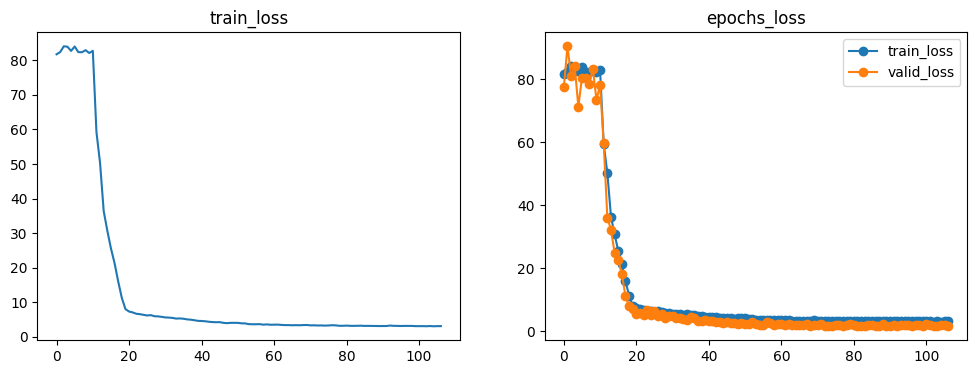

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_epochs_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(valid_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

# Tester

In [10]:
def tester(final=True):
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)

    print("Selecting features...")
    x_train, _, x_test, _, _ = select_feat(train_data, valid_data, test_data, select_all=False)

    test_dataset = COVID19Dataset(x_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    if final:
        model.load_state_dict(torch.load(model_final_path))
        print("***********- ***********- Using Final Model -*************")
    else:
        model.load_state_dict(torch.load(model_best_path))
        print("***********- ***********- Using Best Model -*************")

    print("***********- ***********- Test begin -*************")
    preds = []
    model.eval()
    # =========================test=======================
    for idx, (X) in enumerate(tqdm(test_dataloader)):
        if (len(args.gpus) > 0):
            X = X.cuda()
        with torch.no_grad():
            outputs = model(X)
            preds.append(outputs.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()

    print("***********- ***********- Save predictions -*************")
    save_file = args.submit_file
    with open(save_file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

    print("***********- ***********- Test finished -*************")

# Testing

In [11]:
tester(final=True)

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
Selecting features...
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Using Final Model -*************
***********- ***********- Test begin -*************


100%|██████████| 5/5 [00:00<00:00,  9.95it/s]

***********- ***********- Save predictions -*************
***********- ***********- Test finished -*************
